In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import joblib 
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_absolute_error, make_scorer

In [3]:
df = pd.read_csv('data/merged_climate_iom_data.csv')

In [4]:
# Sorting by country and time to ensure proper filling
df.sort_values(by=["country_code", "year", "month"], inplace=True)

columns_to_fill_extended = [
    "AG.LND.FRST.K2", "AG.LND.PRCP.MM", "AG.LND.TOTL.K2", "AG.SRF.TOTL.K2",
    "EG.CFT.ACCS.RU.ZS", "EG.CFT.ACCS.UR.ZS", "EG.CFT.ACCS.ZS", "EG.EGY.PRIM.PP.KD", "EG.ELC.ACCS.ZS", "EG.FEC.RNEW.ZS",
    "EN.GHG.ALL.MT.CE.AR5", "EN.GHG.CH4.AG.MT.CE.AR5", "EN.GHG.CH4.BU.MT.CE.AR5", "EN.GHG.CH4.FE.MT.CE.AR5",
    "EN.GHG.CH4.IC.MT.CE.AR5", "EN.GHG.CH4.MT.CE.AR5", "EN.GHG.CH4.PI.MT.CE.AR5", "EN.GHG.CH4.TR.MT.CE.AR5",
    "EN.GHG.CH4.WA.MT.CE.AR5", "EN.GHG.CO2.BU.MT.CE.AR5", "EN.GHG.CO2.IC.MT.CE.AR5", "EN.GHG.CO2.IP.MT.CE.AR5",
    "EN.GHG.CO2.LU.MT.CE.AR5", "EN.GHG.CO2.MT.CE.AR5", "EN.GHG.CO2.PI.MT.CE.AR5", "EN.GHG.CO2.TR.MT.CE.AR5",
    "EN.GHG.FGAS.IP.MT.CE.AR5", "EN.GHG.N2O.AG.MT.CE.AR5", "EN.GHG.N2O.BU.MT.CE.AR5", "EN.GHG.N2O.FE.MT.CE.AR5",
    "EN.GHG.N2O.IC.MT.CE.AR5", "EN.GHG.N2O.IP.MT.CE.AR5", "EN.GHG.N2O.MT.CE.AR5", "EN.GHG.N2O.PI.MT.CE.AR5",
    "EN.GHG.N2O.TR.MT.CE.AR5", "EN.GHG.N2O.WA.MT.CE.AR5", "ER.FSH.AQUA.MT", "ER.FSH.CAPT.MT", "ER.FSH.PROD.MT",
    "ER.H2O.FWTL.K3", "ER.H2O.INTR.K3", "SP.POP.TOTL"
]

columns_to_fill_extended = [col.lower() for col in columns_to_fill_extended]

# Filtering columns that exist in the dataset
existing_columns = [col for col in columns_to_fill_extended if col in df.columns]

df[existing_columns] = df.groupby("country_code")[existing_columns].transform(lambda x: x.ffill().bfill())

In [5]:
df['total_idp_over_pop'] = (df['internally_displaced_persons'] / df['sp.pop.totl'])*100
df['total_affected_over_pop'] = (df['total_affected'] / df['sp.pop.totl'])*100

In [6]:
weird_values = df[df['total_idp_over_pop'] > 100]

In [7]:
len(weird_values)

8

In [8]:
weird_values[['year','country_name', 'sp.pop.totl','internally_displaced_persons',  'total_idp_over_pop', 'total_affected_over_pop']].describe()

,year,sp.pop.totl,internally_displaced_persons,total_idp_over_pop,total_affected_over_pop
count,8.000000,8.000000e+00,8.000000e+00,8.000000,3.000000
mean,2022.250000,3.535141e+07,4.878471e+07,129.245549,49.949904
std,1.035098,2.027603e+07,3.285272e+07,29.424648,36.602761
min,2021.000000,1.086578e+07,1.114828e+07,102.599951,7.684676
25%,2021.000000,1.086578e+07,1.205802e+07,110.972392,39.383597
50%,2023.000000,5.004279e+07,5.963956e+07,119.177121,71.082518
75%,2023.000000,5.004279e+07,6.685620e+07,133.598064,71.082518
max,2023.000000,5.004279e+07,9.545158e+07,190.739913,71.082518


In [9]:
# Removing odd values, where we have more than 100% of the population displaced
df = df[df['total_idp_over_pop'] < 100]

In [10]:
env_factors = [
'ag.lnd.frst.k2', 'ag.lnd.prcp.mm',
       'ag.lnd.totl.k2', 'ag.srf.totl.k2', 'eg.cft.accs.ru.zs',
       'eg.cft.accs.ur.zs', 'eg.cft.accs.zs', 'eg.egy.prim.pp.kd',
       'eg.elc.accs.zs', 'eg.fec.rnew.zs', 'en.ghg.all.mt.ce.ar5',
       'en.ghg.ch4.ag.mt.ce.ar5', 'en.ghg.ch4.bu.mt.ce.ar5',
       'en.ghg.ch4.fe.mt.ce.ar5', 'en.ghg.ch4.ic.mt.ce.ar5',
       'en.ghg.ch4.mt.ce.ar5', 'en.ghg.ch4.pi.mt.ce.ar5',
       'en.ghg.ch4.tr.mt.ce.ar5', 'en.ghg.ch4.wa.mt.ce.ar5',
       'en.ghg.co2.bu.mt.ce.ar5', 'en.ghg.co2.ic.mt.ce.ar5',
       'en.ghg.co2.ip.mt.ce.ar5', 'en.ghg.co2.lu.mt.ce.ar5',
       'en.ghg.co2.mt.ce.ar5', 'en.ghg.co2.pi.mt.ce.ar5',
       'en.ghg.co2.tr.mt.ce.ar5', 'en.ghg.fgas.ip.mt.ce.ar5',
       'en.ghg.n2o.ag.mt.ce.ar5', 'en.ghg.n2o.bu.mt.ce.ar5',
       'en.ghg.n2o.fe.mt.ce.ar5', 'en.ghg.n2o.ic.mt.ce.ar5',
       'en.ghg.n2o.ip.mt.ce.ar5', 'en.ghg.n2o.mt.ce.ar5',
       'en.ghg.n2o.pi.mt.ce.ar5', 'en.ghg.n2o.tr.mt.ce.ar5',
       'en.ghg.n2o.wa.mt.ce.ar5', 'er.fsh.aqua.mt', 'er.fsh.capt.mt',
       'er.fsh.prod.mt', 'er.h2o.fwtl.k3', 'er.h2o.intr.k3', 'sp.pop.totl',
       'cpi_value', 'total_affected']

#impute mean to nas in env_factors

for col in env_factors:
       if col == 'total_affected':
              df[col].fillna(0, inplace=True)
       else:
              df[col].fillna(df[col].mean(), inplace=True)

# Drop rows with missing values in the selected columns
df_clean = df[["internally_displaced_persons"] + env_factors].dropna()

# Define independent (X) and dependent (y) variables
X = df_clean[env_factors]  # Environmental factors
y = df_clean["internally_displaced_persons"]  # Displacement

# Add a constant term for the regression model
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Display model summary
model.summary()


/var/folders/p2/6x334wb90dvdf75sfntm2bxw0000gn/T/ipykernel_4299/212894501.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace=True)
/var/folders/p2/6x334wb90dvdf75sfntm2bxw0000gn/T/ipykernel_4299/212894501.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always beh

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     internally_displaced_persons   R-squared:                       0.211
Model:                                      OLS   Adj. R-squared:                  0.171
Method:                           Least Squares   F-statistic:                     5.252
Date:                          Sat, 10 May 2025   Prob (F-statistic):           1.97e-23
Time:                                  19:14:34   Log-Likelihood:                -14999.
No. Observations:                           909   AIC:                         3.009e+04
Df Residuals:                               864   BIC:                         3.030e+04
Df Model:                                    44                                         
Covariance Type:                      nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                     3.237e+06   3.02e+06      1.072      0.284   -2.69e+06    9.16e+06
ag.lnd.frst.k2              19.2867      5.671      3.401      0.001       8.156      30.417
ag.lnd.prcp.mm            -463.9945   1237.873     -0.375      0.708   -2893.585    1965.596
ag.lnd.totl.k2              40.0616     41.154      0.973      0.331     -40.713     120.836
ag.srf.totl.k2             -42.5073     40.494     -1.050      0.294    -121.985      36.970
eg.cft.accs.ru.zs         5.424e+04   7.87e+04      0.689      0.491      -1e+05    2.09e+05
eg.cft.accs.ur.zs        -2.962e+04   3.56e+04     -0.833      0.405   -9.94e+04    4.02e+04
eg.cft.accs.zs             1.01e+04   1.02e+05      0.099      0.921   -1.89e+05     2.1e+05
eg.egy.prim.pp.kd        -3.259e+05   1.43e+05     -2.279      0.023   -6.07e+05   -4.52e+04
eg.elc.accs.zs           -2124.9844   2.02e+04     -0.105      0.916   -4.18e+04    3.75e+04
eg.fec.rnew.zs            4376.8606    2.4e+04      0.182      0.855   -4.27e+04    5.15e+04
en.ghg.all.mt.ce.ar5      8387.9029   1891.591      4.434      0.000    4675.252    1.21e+04
en.ghg.ch4.ag.mt.ce.ar5   1821.0106   2302.232      0.791      0.429   -2697.610    6339.631
en.ghg.ch4.bu.mt.ce.ar5   -988.4752   1052.830     -0.939      0.348   -3054.878    1077.928
en.ghg.ch4.fe.mt.ce.ar5    155.3699   1932.538      0.080      0.936   -3637.648    3948.388
en.ghg.ch4.ic.mt.ce.ar5  -1833.9923   4065.048     -0.451      0.652   -9812.517    6144.533
en.ghg.ch4.mt.ce.ar5     -2306.9341   1818.750     -1.268      0.205   -5876.620    1262.752
en.ghg.ch4.pi.mt.ce.ar5  -4372.3090   2493.226     -1.754      0.080   -9265.796     521.178
en.ghg.ch4.tr.mt.ce.ar5  -2045.7670   1291.530     -1.584      0.114   -4580.671     489.137
en.ghg.ch4.wa.mt.ce.ar5    186.8762   1517.346      0.123      0.902   -2791.239    3164.991
en.ghg.co2.bu.mt.ce.ar5    606.8015   1470.321      0.413      0.680   -2279.018    3492.621
en.ghg.co2.ic.mt.ce.ar5     63.9020   1063.733      0.060      0.952   -2023.901    2151.705
en.ghg.co2.ip.mt.ce.ar5  -1537.1705   1099.262     -1.398      0.162   -3694.707     620.366
en.ghg.co2.lu.mt.ce.ar5   -391.5273   1626.604     -0.241      0.810   -3584.085    2801.031
en.ghg.co2.mt.ce.ar5     -2053.8027   2516.000     -0.816      0.415   -6991.990    2884.385
en.ghg.co2.pi.mt.ce.ar5   -895.2697   1144.580     -0.782      0.434   -3141.753    1351.213
en.ghg.co2.tr.mt.ce.ar5  -1765.6912   2562.607     -0.689      0.491   -6795.354    3263.972
en.ghg.fgas.ip.mt.ce.ar5 -3220.1125   1310.468     -2.457      0.014   -5792.186    -648.039
en.ghg.n2o.ag.mt.ce.ar5    973.6734   3918.430      0.248      0.804   -6717.082    8664.4

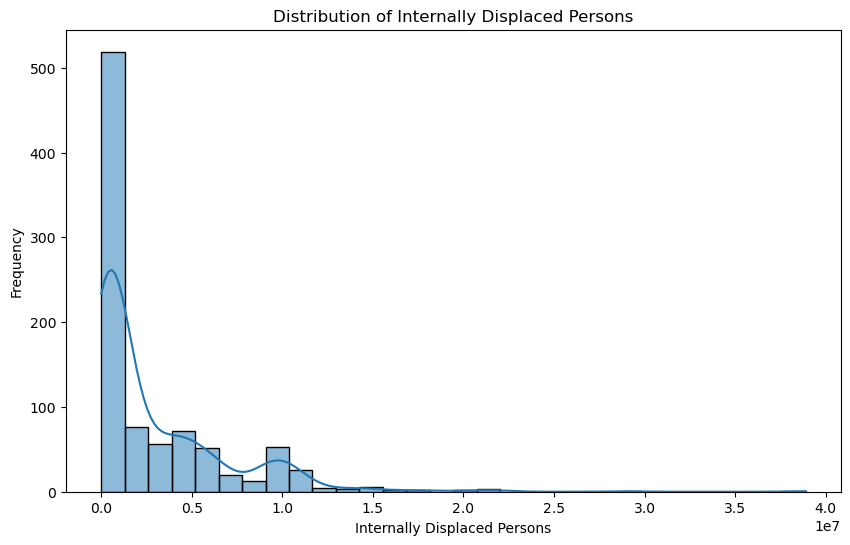

In [11]:
# distribution plot of tartget variable y
plt.figure(figsize=(10, 6))
sns.histplot(y, bins=30, kde=True)
plt.title('Distribution of Internally Displaced Persons')
plt.xlabel('Internally Displaced Persons')
plt.ylabel('Frequency')
plt.show()

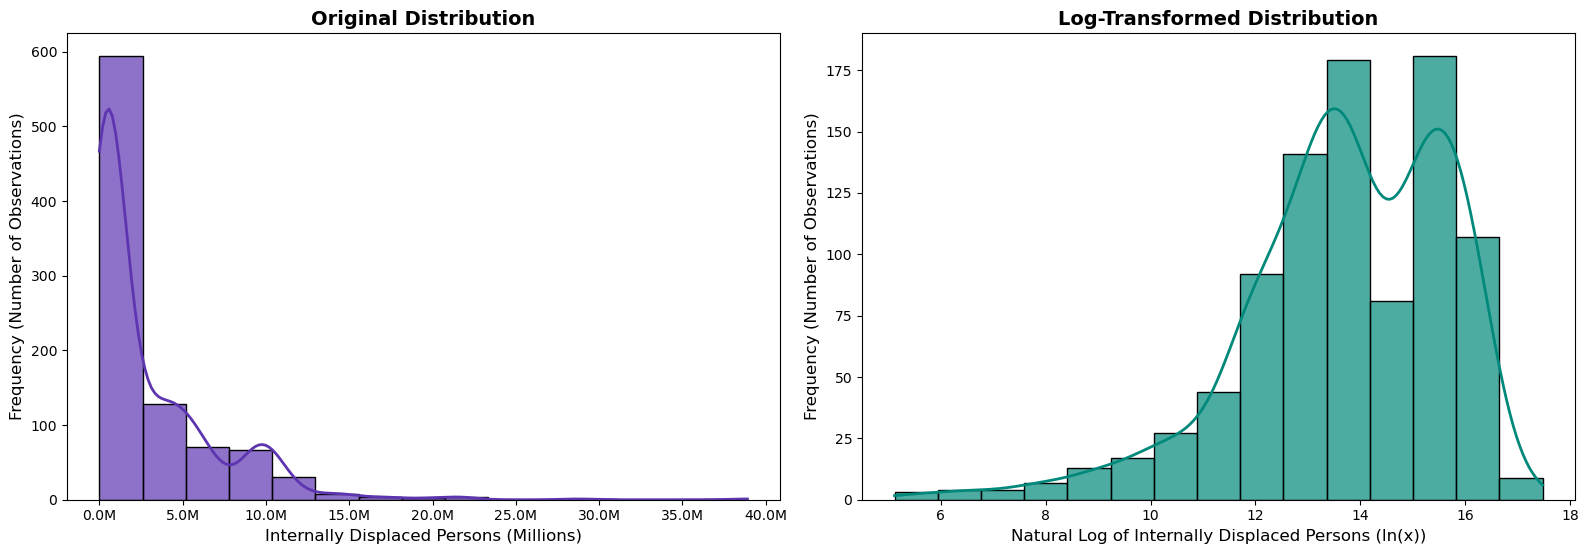

In [12]:
# Import libraries if not already imported
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.ticker as ticker

# Create two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# First subplot - Original distribution
sns.histplot(
    df['internally_displaced_persons'],
    bins=15,
    kde=True,
    color='#5e35b1',
    line_kws={'linewidth': 2, 'color': '#283593'},
    alpha=0.7,
    ax=ax1
)

# Improve original plot formatting
ax1.set_title('Original Distribution', fontsize=14, fontweight='bold')
ax1.set_xlabel('Internally Displaced Persons (Millions)', fontsize=12)
ax1.set_ylabel('Frequency (Number of Observations)', fontsize=12)
ax1.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1e6:.1f}M'))

# Second subplot - Log-transformed distribution
log_data = np.log1p(df['internally_displaced_persons'])  # Using log1p to handle zeros
sns.histplot(
    log_data,
    bins=15,
    kde=True,
    color='#00897b',
    line_kws={'linewidth': 2, 'color': '#00695c'},
    alpha=0.7,
    ax=ax2
)

ax2.set_title('Log-Transformed Distribution', fontsize=14, fontweight='bold')
ax2.set_xlabel('Natural Log of Internally Displaced Persons (ln(x))', fontsize=12)
ax2.set_ylabel('Frequency (Number of Observations)', fontsize=12)

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

#### OLS Regression

In [13]:
# Split data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the regression model on the training set
model_train = sm.OLS(y_train, X_train).fit()

# Predict on the test set
y_pred = model_train.predict(X_test)

# Evaluate model performance
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae, r2

(2444481.8900927, 0.07131616426679233)

#### Cross Validation for the OLS Model:
- First intent with K fold
- Note for fixing:  Do cross validation in the proportion of affected / total

In [14]:
# 1. Set up K-Fold cross-validation
k = 10
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# 2. Initialize lists to store metrics
mae_scores = []
r2_scores = []

# 3. Perform manual cross-validation with statsmodels
for train_index, test_index in kf.split(X):
    # Split data for this fold
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    
    # Train statsmodels OLS
    model_fold = sm.OLS(y_train_fold, X_train_fold).fit()
    
    # Make predictions
    y_pred_fold = model_fold.predict(X_test_fold)
    
    # Calculate and store performance metrics
    mae = mean_absolute_error(y_test_fold, y_pred_fold)
    r2 = r2_score(y_test_fold, y_pred_fold)
    
    mae_scores.append(mae)
    r2_scores.append(r2)

# 4. Calculate average performance
avg_mae = np.mean(mae_scores)
avg_r2 = np.mean(r2_scores)
std_mae = np.std(mae_scores)
std_r2 = np.std(r2_scores)

print(f"Cross-validation MAE: {avg_mae:.4f} ± {std_mae:.4f}")
print(f"Cross-validation R²: {avg_r2:.4f} ± {std_r2:.4f}")

Cross-validation MAE: 2509150.3177 ± 309703.9148
Cross-validation R²: 0.1106 ± 0.1586


#### Random Forest Model

In [15]:
# Convert categorical variables to numerical using one-hot encoding
df_encoded = pd.get_dummies(df_clean.drop(columns=["internally_displaced_persons"]), drop_first=True)

# Fill missing values with the median
#df_encoded = df_encoded.fillna(df_encoded.median(numeric_only=True))
#y_filled = df["internally_displaced_persons"]

# Split into train and test sets
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(df_encoded[env_factors], y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_rf, y_train_rf)

# Predict on test set
y_pred_rf = rf_model.predict(X_test_rf)

# Evaluate model performance
mae_rf = mean_absolute_error(y_test_rf, y_pred_rf)
r2_rf = r2_score(y_test_rf, y_pred_rf)

mae_rf, r2_rf

(882339.3576808905, 0.754532961664351)

#### Cross Validation for the Random Forest Model

In [16]:
# Setup K-fold cross-validation
k = 5  # adjust?? i think this is already pretty solid
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Initialize the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Prepare data
X = df_encoded[env_factors]
y = y

# Initialize lists to store performance metrics
mae_scores = []
r2_scores = []

# Perform cross-validation
for train_index, test_index in kf.split(X):
    # Split data for this fold
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    
    # Train model
    rf_model.fit(X_train_fold, y_train_fold)
    
    # Make predictions
    y_pred_fold = rf_model.predict(X_test_fold)
    
    # Calculate and store performance metrics
    mae = mean_absolute_error(y_test_fold, y_pred_fold)
    r2 = r2_score(y_test_fold, y_pred_fold)
    
    mae_scores.append(mae)
    r2_scores.append(r2)

# Calculate average performance
avg_mae = np.mean(mae_scores)
avg_r2 = np.mean(r2_scores)
std_mae = np.std(mae_scores)
std_r2 = np.std(r2_scores)

print(f"Cross-validation MAE: {avg_mae:.4f} ± {std_mae:.4f}")
print(f"Cross-validation R²: {avg_r2:.4f} ± {std_r2:.4f}")

Cross-validation MAE: 1171795.8819 ± 156792.7779
Cross-validation R²: 0.6225 ± 0.0845


In [17]:
# Ridge doesn't take NAs, so we nede to impute them. The highest NAs we have are in variables that are about climate catastrophes, 
# where where we have them it means that there was NO climate catastrophe, so we can impute a 0 to them.

df_encoded.isna().sum().sort_values(ascending=False).head(20)
# impute a 0 to all the nas in the encoded df
df_encoded = df_encoded.fillna(0)

# Prepare data
X = df_encoded[env_factors]
y = y

#### Cross Validation for Ridge

In [18]:
# Create a pipeline that first standardizes, then applies Ridge regression
ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge(alpha=1.0))
])

# Create scorers
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
r2_scorer = make_scorer(r2_score)

# Run cross-validation with the pipeline
ridge_mae_scores = -cross_val_score(ridge_pipeline, X, y, cv=5, scoring=mae_scorer)
ridge_r2_scores = cross_val_score(ridge_pipeline, X, y, cv=5, scoring=r2_scorer)

print("Ridge Cross-validation Results (with Pipeline):")
print(f"Cross-validation MAE: {ridge_mae_scores.mean():.4f} ± {ridge_mae_scores.std():.4f}")
print(f"Cross-validation R²: {ridge_r2_scores.mean():.4f} ± {ridge_r2_scores.std():.4f}")

Ridge Cross-validation Results (with Pipeline):
Cross-validation MAE: 2902553.8435 ± 429143.0495
Cross-validation R²: -4.9837 ± 9.6314


In [19]:
# Lasso model
lasso_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', Lasso(alpha=0.1))
])
# create scorers lasso
lasso_mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
lasso_r2_scorer = make_scorer(r2_score)

# Run cross-validation with the pipeline
lasso_mae_scores = -cross_val_score(lasso_pipeline, X, y, cv=5, scoring=lasso_mae_scorer)
lasso_r2_scores = cross_val_score(lasso_pipeline, X, y, cv=5, scoring=lasso_r2_scorer)

# print results
print("Lasso Cross-validation Results (with Pipeline):")
print(f"Cross-validation MAE: {lasso_mae_scores.mean():.4f} ± {lasso_mae_scores.std():.4f}")
print(f"Cross-validation R²: {lasso_r2_scores.mean():.4f} ± {lasso_r2_scores.std():.4f}")

/Applications/anaconda3/envs/ml2025/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.631e+15, tolerance: 1.178e+12
  model = cd_fast.enet_coordinate_descent(
/Applications/anaconda3/envs/ml2025/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.229e+15, tolerance: 1.203e+12
  model = cd_fast.enet_coordinate_descent(
/Applications/anaconda3/envs/ml2025/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or co

Lasso Cross-validation Results (with Pipeline):
Cross-validation MAE: 2911180.4146 ± 428123.4710
Cross-validation R²: -4.9954 ± 9.6412


/Applications/anaconda3/envs/ml2025/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.102e+15, tolerance: 1.089e+12
  model = cd_fast.enet_coordinate_descent(


In [21]:
#Save models 

joblib.dump(model, 'models/ols_model.pkl')
joblib.dump(ridge_pipeline, 'models/ridge_model.pkl')
joblib.dump(lasso_pipeline, 'models/lasso_model.pkl')
joblib.dump(rf_model, 'models/rf_model.pkl')


['models/rf_model.pkl']